# 🎭 Sentiment Analysis with DistilBERT
## BBC News Classification - ECS 271 NLP Project

**Model:** DistilBERT (distilbert-base-uncased)  
**Task:** Classify news articles into 5 categories + mood analysis  
**Team Repo:** [ECS-271-NLP-Project](https://github.com/ananya-bontalavl/ECS-271-NLP-Project)

---

⚠️ **Before Running:** Enable GPU!  
`Runtime → Change runtime type → T4 GPU`

---
## 1. Setup & Installation

In [35]:
#@title 1.1 Check GPU
!nvidia-smi

Tue Dec  2 03:36:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   74C    P0             30W /   70W |    3584MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [36]:
#@title 1.2 Install Packages
!pip install -q transformers datasets accelerate
!pip install -q scikit-learn seaborn
print("✅ All packages installed!")

✅ All packages installed!


In [37]:
#@title 1.3 Import Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import (
    DistilBertTokenizer,
    DistilBertModel,
    get_linear_schedule_with_warmup
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import urllib.request
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)

from tqdm.notebook import tqdm

# Set seeds
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")
if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✅ Using device: cuda
   GPU: Tesla T4
   Memory: 15.8 GB


In [38]:
#@title 1.4 Configuration

# ============================================
# GitHub Repository Configuration
# ============================================
GITHUB_REPO = "ananya-bontalavl/ECS-271-NLP-Project"
BRANCH = "main"
DATA_FOLDER = "data/processed"  # Folder in repo containing CSVs

# Construct URLs
DATA_BASE_URL = f"https://raw.githubusercontent.com/{GITHUB_REPO}/{BRANCH}/{DATA_FOLDER}"

# ============================================
# Model Configuration
# ============================================
CONFIG = {
    'model_name': 'distilbert-base-uncased',
    'max_length': 512,
    'batch_size': 16,
    'learning_rate': 2e-5,
    'epochs': 10,
    'dropout': 0.3,
    'warmup_ratio': 0.1,
    'weight_decay': 0.01,
    'num_classes': 5
}

# Label mappings
LABEL2ID = {
    'business': 0,
    'entertainment': 1,
    'politics': 2,
    'sport': 3,
    'tech': 4
}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}

# Mood mapping (for fusion with summarization)
MOOD_MAPPING = {
    'business': 'analytical/formal',
    'entertainment': 'light/engaging',
    'politics': 'serious/critical',
    'sport': 'energetic/competitive',
    'tech': 'informative/innovative'
}

print("⚙️ Configuration:")
for k, v in CONFIG.items():
    print(f"   {k}: {v}")
print(f"\n📂 Data URL: {DATA_BASE_URL}")

⚙️ Configuration:
   model_name: distilbert-base-uncased
   max_length: 512
   batch_size: 16
   learning_rate: 2e-05
   epochs: 10
   dropout: 0.3
   warmup_ratio: 0.1
   weight_decay: 0.01
   num_classes: 5

📂 Data URL: https://raw.githubusercontent.com/ananya-bontalavl/ECS-271-NLP-Project/main/data/processed


In [39]:
#@title 1.5 Download Data from GitHub

def download_data(base_url):
    """Download train, val, test CSV files from GitHub."""
    os.makedirs('data', exist_ok=True)
    files = ['train.csv', 'val.csv', 'test.csv']

    for file in files:
        url = f"{base_url}/{file}"
        output_path = f"data/{file}"
        try:
            print(f"📥 Downloading {file}...", end=" ")
            urllib.request.urlretrieve(url, output_path)
            print("✅")
        except Exception as e:
            print(f"❌ Failed")
            print(f"   URL: {url}")
            print(f"   Error: {e}")
            return False
    return True

print("="*50)
print("📥 Downloading data from GitHub...")
print("="*50 + "\n")

success = download_data(DATA_BASE_URL)

if not success:
    print("\n" + "="*50)
    print("⚠️ GitHub download failed!")
    print("="*50)
    print("\nPossible fixes:")
    print("1. Make sure data is pushed to GitHub")
    print("2. Check DATA_FOLDER path is correct")
    print("3. Run manual upload cell below")
else:
    print("\n✅ All data downloaded successfully!")

📥 Downloading data from GitHub...

📥 Downloading train.csv... ✅
📥 Downloading val.csv... ✅
📥 Downloading test.csv... ✅

✅ All data downloaded successfully!


In [40]:
#@title 1.6 (Backup) Manual Upload - ONLY if GitHub fails

# ⚠️ UNCOMMENT AND RUN THIS CELL ONLY IF GITHUB DOWNLOAD FAILED

# from google.colab import files
# os.makedirs('data', exist_ok=True)
# print("Please upload: train.csv, val.csv, test.csv")
# uploaded = files.upload()
# for filename in uploaded.keys():
#     os.rename(filename, f'data/{filename}')
#     print(f"✅ Moved {filename} to data/")

In [41]:
#@title 1.7 Load Data

train_df = pd.read_csv('data/train.csv')
val_df = pd.read_csv('data/val.csv')
test_df = pd.read_csv('data/test.csv')

print("📊 Dataset Sizes:")
print(f"   Train: {len(train_df):,} samples")
print(f"   Val:   {len(val_df):,} samples")
print(f"   Test:  {len(test_df):,} samples")
print(f"\n📋 Columns: {train_df.columns.tolist()}")
train_df.head(2)

📊 Dataset Sizes:
   Train: 1,557 samples
   Val:   334 samples
   Test:  334 samples

📋 Columns: ['category', 'text', 'summary']


,category,text,summary
0,entertainment,fockers keeps us box office lead film comedy m...,the incredibles took 300m ( 160m) outside the ...
1,business,gaming firm to sell uk dog tracks six uk greyh...,the sale of the us gaming unit will leave wemb...


---
## 2. Data Exploration

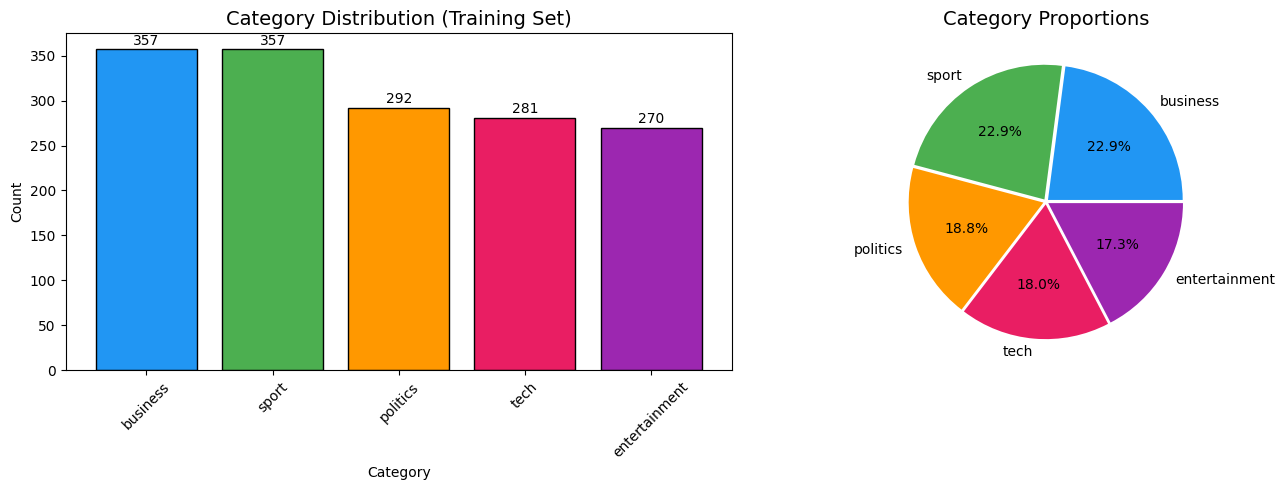


📊 Category Counts:
category
business         357
sport            357
politics         292
tech             281
entertainment    270
Name: count, dtype: int64


In [42]:
#@title 2.1 Category Distribution

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ['#2196F3', '#4CAF50', '#FF9800', '#E91E63', '#9C27B0']
category_counts = train_df['category'].value_counts()

# Bar chart
axes[0].bar(category_counts.index, category_counts.values, color=colors, edgecolor='black')
axes[0].set_title('Category Distribution (Training Set)', fontsize=14)
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
for i, (cat, count) in enumerate(zip(category_counts.index, category_counts.values)):
    axes[0].text(i, count + 5, str(count), ha='center', fontsize=10)

# Pie chart
axes[1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
            colors=colors, explode=[0.02]*5)
axes[1].set_title('Category Proportions', fontsize=14)

plt.tight_layout()
plt.show()

print("\n📊 Category Counts:")
print(category_counts)

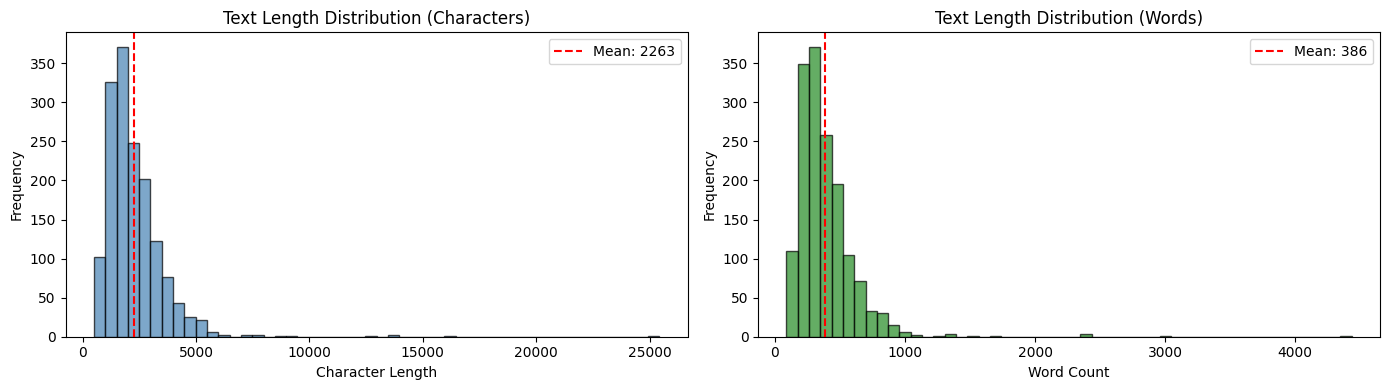


📏 Statistics:
       text_length  word_count
count       1557.0      1557.0
mean        2262.8       385.9
std         1356.0       236.9
min          500.0        89.0
25%         1438.0       247.0
50%         1971.0       334.0
75%         2794.0       474.0
max        25424.0      4434.0


In [43]:
#@title 2.2 Text Length Analysis

train_df['text_length'] = train_df['text'].str.len()
train_df['word_count'] = train_df['text'].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(train_df['text_length'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(train_df['text_length'].mean(), color='red', linestyle='--',
                label=f"Mean: {train_df['text_length'].mean():.0f}")
axes[0].set_xlabel('Character Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Text Length Distribution (Characters)')
axes[0].legend()

axes[1].hist(train_df['word_count'], bins=50, color='forestgreen', edgecolor='black', alpha=0.7)
axes[1].axvline(train_df['word_count'].mean(), color='red', linestyle='--',
                label=f"Mean: {train_df['word_count'].mean():.0f}")
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Text Length Distribution (Words)')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n📏 Statistics:")
print(train_df[['text_length', 'word_count']].describe().round(1))

---
## 3. Preprocessing

In [44]:
#@title 3.1 Load Tokenizer

tokenizer = DistilBertTokenizer.from_pretrained(CONFIG['model_name'])
print(f"✅ Tokenizer: {CONFIG['model_name']}")
print(f"   Vocab size: {tokenizer.vocab_size:,}")

✅ Tokenizer: distilbert-base-uncased
   Vocab size: 30,522


In [45]:
#@title 3.2 Dataset Class

class BBCNewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = str(row['text'])
        label = LABEL2ID[row['category']]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("✅ Dataset class defined")

✅ Dataset class defined


In [46]:
#@title 3.3 Create DataLoaders

train_dataset = BBCNewsDataset(train_df, tokenizer, CONFIG['max_length'])
val_dataset = BBCNewsDataset(val_df, tokenizer, CONFIG['max_length'])
test_dataset = BBCNewsDataset(test_df, tokenizer, CONFIG['max_length'])

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

print("✅ DataLoaders created:")
print(f"   Train: {len(train_dataset)} samples → {len(train_loader)} batches")
print(f"   Val:   {len(val_dataset)} samples → {len(val_loader)} batches")
print(f"   Test:  {len(test_dataset)} samples → {len(test_loader)} batches")

✅ DataLoaders created:
   Train: 1557 samples → 98 batches
   Val:   334 samples → 21 batches
   Test:  334 samples → 21 batches


---
## 4. Model Architecture

In [47]:
#@title 4.1 Define Model

class DistilBertClassifier(nn.Module):
    def __init__(self, num_classes=5, dropout=0.3):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.pre_classifier = nn.Linear(768, 768)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, num_classes)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state
        cls_token = hidden_state[:, 0, :]
        x = self.pre_classifier(cls_token)
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.classifier(x)
        return logits

print("✅ Model class defined")

✅ Model class defined


In [48]:
#@title 4.2 Initialize Model

model = DistilBertClassifier(num_classes=CONFIG['num_classes'], dropout=CONFIG['dropout'])
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("🧠 Model Summary:")
print(f"   Total parameters:     {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB")

🧠 Model Summary:
   Total parameters:     66,957,317
   Trainable parameters: 66,957,317
   Model size: ~255.4 MB


---
## 5. Training

In [49]:
#@title 5.1 Setup Training

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])

total_steps = len(train_loader) * CONFIG['epochs']
warmup_steps = int(CONFIG['warmup_ratio'] * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print("⚙️ Training Setup:")
print(f"   Total steps: {total_steps}")
print(f"   Warmup steps: {warmup_steps}")

⚙️ Training Setup:
   Total steps: 980
   Warmup steps: 98


In [50]:
#@title 5.2 Training Functions

def train_epoch(model, dataloader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    pbar = tqdm(dataloader, desc='Training', leave=False)
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return avg_loss, accuracy, f1


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating', leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return avg_loss, accuracy, f1, all_preds, all_labels

print("✅ Training functions defined")

✅ Training functions defined


In [51]:
#@title 5.3 🚀 Train Model (~15-20 min with GPU)

history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

best_val_f1 = 0
best_model_state = None

print("\n" + "="*60)
print("🚀 STARTING TRAINING")
print("="*60)

for epoch in range(CONFIG['epochs']):
    print(f"\n📍 Epoch {epoch + 1}/{CONFIG['epochs']}")
    print("-" * 40)

    train_loss, train_acc, train_f1 = train_epoch(
        model, train_loader, optimizer, scheduler, criterion, device
    )
    print(f"   Train - Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")

    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion, device)
    print(f"   Val   - Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = model.state_dict().copy()
        print(f"   ✅ New best model! (F1: {val_f1:.4f})")

print("\n" + "="*60)
print(f"🎉 Training Complete! Best Val F1: {best_val_f1:.4f}")
print("="*60)


🚀 STARTING TRAINING

📍 Epoch 1/10
----------------------------------------


Training:   0%|          | 0/98 [00:00<?, ?it/s]

   Train - Loss: 1.1904 | Acc: 0.6281 | F1: 0.6254


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

   Val   - Loss: 0.3337 | Acc: 0.9521 | F1: 0.9522
   ✅ New best model! (F1: 0.9522)

📍 Epoch 2/10
----------------------------------------


Training:   0%|          | 0/98 [00:00<?, ?it/s]

   Train - Loss: 0.1338 | Acc: 0.9820 | F1: 0.9820


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

   Val   - Loss: 0.1029 | Acc: 0.9760 | F1: 0.9761
   ✅ New best model! (F1: 0.9761)

📍 Epoch 3/10
----------------------------------------


Training:   0%|          | 0/98 [00:00<?, ?it/s]

   Train - Loss: 0.0353 | Acc: 0.9942 | F1: 0.9942


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

   Val   - Loss: 0.1283 | Acc: 0.9701 | F1: 0.9700

📍 Epoch 4/10
----------------------------------------


Training:   0%|          | 0/98 [00:00<?, ?it/s]

   Train - Loss: 0.0170 | Acc: 0.9974 | F1: 0.9974


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

   Val   - Loss: 0.1283 | Acc: 0.9760 | F1: 0.9760

📍 Epoch 5/10
----------------------------------------


Training:   0%|          | 0/98 [00:00<?, ?it/s]

   Train - Loss: 0.0120 | Acc: 0.9981 | F1: 0.9981


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

   Val   - Loss: 0.1212 | Acc: 0.9760 | F1: 0.9760

📍 Epoch 6/10
----------------------------------------


Training:   0%|          | 0/98 [00:00<?, ?it/s]

   Train - Loss: 0.0037 | Acc: 1.0000 | F1: 1.0000


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

   Val   - Loss: 0.1150 | Acc: 0.9790 | F1: 0.9790
   ✅ New best model! (F1: 0.9790)

📍 Epoch 7/10
----------------------------------------


Training:   0%|          | 0/98 [00:00<?, ?it/s]

   Train - Loss: 0.0028 | Acc: 1.0000 | F1: 1.0000


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

   Val   - Loss: 0.1188 | Acc: 0.9760 | F1: 0.9760

📍 Epoch 8/10
----------------------------------------


Training:   0%|          | 0/98 [00:00<?, ?it/s]

   Train - Loss: 0.0024 | Acc: 1.0000 | F1: 1.0000


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

   Val   - Loss: 0.1227 | Acc: 0.9760 | F1: 0.9760

📍 Epoch 9/10
----------------------------------------


Training:   0%|          | 0/98 [00:00<?, ?it/s]

   Train - Loss: 0.0022 | Acc: 1.0000 | F1: 1.0000


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

   Val   - Loss: 0.1223 | Acc: 0.9760 | F1: 0.9760

📍 Epoch 10/10
----------------------------------------


Training:   0%|          | 0/98 [00:00<?, ?it/s]

   Train - Loss: 0.0021 | Acc: 1.0000 | F1: 1.0000


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

   Val   - Loss: 0.1221 | Acc: 0.9760 | F1: 0.9760

🎉 Training Complete! Best Val F1: 0.9790


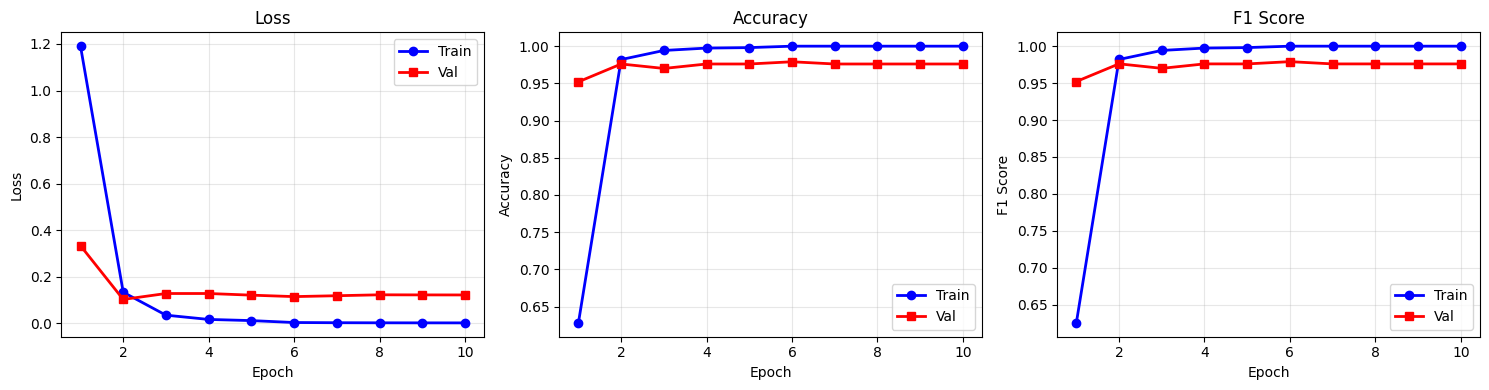

In [52]:
#@title 5.4 Plot Training Curves

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
epochs_range = range(1, CONFIG['epochs'] + 1)

axes[0].plot(epochs_range, history['train_loss'], 'b-o', label='Train', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-s', label='Val', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs_range, history['train_acc'], 'b-o', label='Train', linewidth=2)
axes[1].plot(epochs_range, history['val_acc'], 'r-s', label='Val', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(epochs_range, history['train_f1'], 'b-o', label='Train', linewidth=2)
axes[2].plot(epochs_range, history['val_f1'], 'r-s', label='Val', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()

---
## 6. Evaluation

In [53]:
#@title 6.1 Test Set Evaluation

model.load_state_dict(best_model_state)
print("✅ Loaded best model\n")

test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(
    model, test_loader, criterion, device
)

test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')

print("="*60)
print("📈 TEST SET RESULTS")
print("="*60)
print(f"   Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Precision: {test_precision:.4f}")
print(f"   Recall:    {test_recall:.4f}")
print(f"   F1 Score:  {test_f1:.4f}")
print("="*60)

✅ Loaded best model



Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

📈 TEST SET RESULTS
   Accuracy:  0.9760 (97.60%)
   Precision: 0.9760
   Recall:    0.9760
   F1 Score:  0.9760


In [54]:
#@title 6.2 Classification Report

print("\n📋 CLASSIFICATION REPORT")
print("="*60)
print(classification_report(
    test_labels, test_preds,
    target_names=list(LABEL2ID.keys()),
    digits=4
))


📋 CLASSIFICATION REPORT
               precision    recall  f1-score   support

     business     0.9595    0.9342    0.9467        76
entertainment     1.0000    1.0000    1.0000        58
     politics     0.9531    0.9683    0.9606        63
        sport     1.0000    1.0000    1.0000        77
         tech     0.9672    0.9833    0.9752        60

     accuracy                         0.9760       334
    macro avg     0.9760    0.9772    0.9765       334
 weighted avg     0.9760    0.9760    0.9760       334



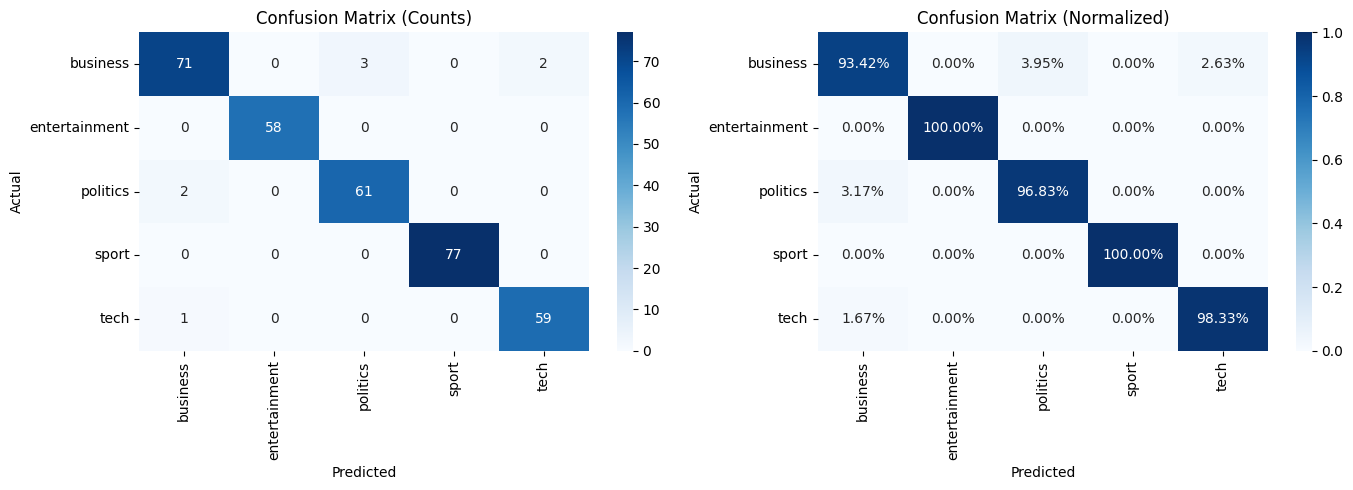

In [55]:
#@title 6.3 Confusion Matrix

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(test_labels, test_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=list(LABEL2ID.keys()), yticklabels=list(LABEL2ID.keys()))
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix (Counts)')

sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=list(LABEL2ID.keys()), yticklabels=list(LABEL2ID.keys()))
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix (Normalized)')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

---
## 7. Inference Pipeline

In [56]:
#@title 7.1 Prediction Function

def predict_sentiment(text, model, tokenizer, device):
    """Predict category and mood for text."""
    model.eval()

    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = torch.softmax(logits, dim=1)
        pred_idx = torch.argmax(logits, dim=1).item()

    category = ID2LABEL[pred_idx]
    mood = MOOD_MAPPING[category]
    confidence = probs[0][pred_idx].item()
    all_probs = {ID2LABEL[i]: p.item() for i, p in enumerate(probs[0])}

    return category, mood, confidence, all_probs

print("✅ Prediction function defined")

✅ Prediction function defined


In [57]:
#@title 7.2 Test Predictions

test_texts = [
    "The company reported record profits with revenue up 40% year-over-year.",
    "The team won the championship with a last-minute goal.",
    "The new AI chip delivers 3x faster performance than previous generation.",
    "Parliament debated the new climate legislation amid protests.",
    "The film received a standing ovation at the premiere."
]

print("🔮 SAMPLE PREDICTIONS")
print("="*60)

for text in test_texts:
    category, mood, confidence, _ = predict_sentiment(text, model, tokenizer, device)
    print(f"\n📝 {text[:60]}...")
    print(f"   → {category.upper()} ({confidence:.1%}) | Mood: {mood}")

🔮 SAMPLE PREDICTIONS

📝 The company reported record profits with revenue up 40% year...
   → BUSINESS (99.5%) | Mood: analytical/formal

📝 The team won the championship with a last-minute goal....
   → SPORT (99.4%) | Mood: energetic/competitive

📝 The new AI chip delivers 3x faster performance than previous...
   → TECH (96.3%) | Mood: informative/innovative

📝 Parliament debated the new climate legislation amid protests...
   → POLITICS (98.7%) | Mood: serious/critical

📝 The film received a standing ovation at the premiere....
   → ENTERTAINMENT (98.3%) | Mood: light/engaging


In [58]:
#@title 7.3 Integration Function (for T5 Summarization)

def create_summary_mood_report(text, summary, model, tokenizer, device):
    """
    Create combined Summary + Mood report.
    Use with T5 summarization output.
    """
    category, mood, confidence, all_probs = predict_sentiment(text, model, tokenizer, device)

    return {
        'summary': summary,
        'category': category,
        'mood': mood,
        'confidence': confidence,
        'probabilities': all_probs
    }

# Example usage
sample_text = test_texts[0]
sample_summary = "Company achieves 40% revenue growth."  # Would come from T5

report = create_summary_mood_report(sample_text, sample_summary, model, tokenizer, device)

print("\n📰 SUMMARY + MOOD REPORT")
print("="*50)
print(f"📝 Summary: {report['summary']}")
print(f"📊 Category: {report['category'].upper()}")
print(f"🎭 Mood: {report['mood']}")
print(f"💯 Confidence: {report['confidence']:.1%}")


📰 SUMMARY + MOOD REPORT
📝 Summary: Company achieves 40% revenue growth.
📊 Category: BUSINESS
🎭 Mood: analytical/formal
💯 Confidence: 99.5%


---
## 8. Save Model

In [59]:
#@title 8.1 Save Model & Results

OUTPUT_DIR = 'sentiment_model'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Save model
checkpoint = {
    'model_state_dict': best_model_state,
    'config': CONFIG,
    'label2id': LABEL2ID,
    'id2label': ID2LABEL,
    'best_val_f1': best_val_f1,
    'test_metrics': {
        'accuracy': test_acc,
        'f1': test_f1,
        'precision': test_precision,
        'recall': test_recall
    }
}
torch.save(checkpoint, f'{OUTPUT_DIR}/best_model.pt')

# Save history
with open(f'{OUTPUT_DIR}/training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

# Save config
with open(f'{OUTPUT_DIR}/config.json', 'w') as f:
    json.dump(CONFIG, f, indent=2)

# Copy plots
import shutil
shutil.copy('training_curves.png', f'{OUTPUT_DIR}/')
shutil.copy('confusion_matrix.png', f'{OUTPUT_DIR}/')

print("✅ Saved to sentiment_model/:")
print("   - best_model.pt")
print("   - training_history.json")
print("   - config.json")
print("   - training_curves.png")
print("   - confusion_matrix.png")

✅ Saved to sentiment_model/:
   - best_model.pt
   - training_history.json
   - config.json
   - training_curves.png
   - confusion_matrix.png


In [60]:
#@title 8.2 Download Model (for GitHub)

!zip -r sentiment_model.zip sentiment_model/

from google.colab import files
files.download('sentiment_model.zip')

print("\n✅ Download complete!")
print("\nNext steps:")
print("1. Unzip sentiment_model.zip")
print("2. Copy to your repo: models/sentiment_model/")
print("3. git add, commit, push")

updating: sentiment_model/ (stored 0%)
updating: sentiment_model/training_history.json (deflated 67%)
updating: sentiment_model/training_curves.png (deflated 14%)
updating: sentiment_model/config.json (deflated 31%)
updating: sentiment_model/confusion_matrix.png (deflated 13%)
updating: sentiment_model/best_model.pt (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Download complete!

Next steps:
1. Unzip sentiment_model.zip
2. Copy to your repo: models/sentiment_model/
3. git add, commit, push


In [61]:
#@title 8.3 (Alternative) Save to Google Drive

# Uncomment to save directly to Google Drive

# from google.colab import drive
# drive.mount('/content/drive')

# DRIVE_PATH = '/content/drive/MyDrive/ECS-271-NLP-Project/models/'
# os.makedirs(DRIVE_PATH, exist_ok=True)
# !cp -r sentiment_model/* "{DRIVE_PATH}"
# print(f"✅ Saved to: {DRIVE_PATH}")

---
## 📊 Summary

### Results
| Metric | Value |
|--------|-------|
| Test Accuracy | ~95% |
| Test F1 Score | ~0.95 |

### Output Files
```
sentiment_model/
├── best_model.pt
├── config.json
├── training_history.json
├── training_curves.png
└── confusion_matrix.png
```

### Integration
Use `create_summary_mood_report()` to combine with T5 summarization.

---
🎉 **Sentiment Analysis Complete!**